In [1]:
import pandas as pd

d = pd.read_csv('Chr20FuncIntx.tsv', sep='\t', header=0)

In [2]:
import networkx as nx
from networkx.algorithms import community


In [65]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from matplotlib import collections  as mc

In [4]:
vertices = set(list(d['a']) + list(d['b']))
edges = [(r['a'], r['b']) for i, r in d.iterrows()]
weights = [r['score'] for i, r in d.iterrows()]

In [5]:
g = nx.Graph()
g.add_nodes_from(list(vertices))
g.add_edges_from(edges)

In [6]:
# TODO find a good community detection fcn
# TODO add edge weights?
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

In [7]:
communities = sorted(map(sorted, next_level_communities))

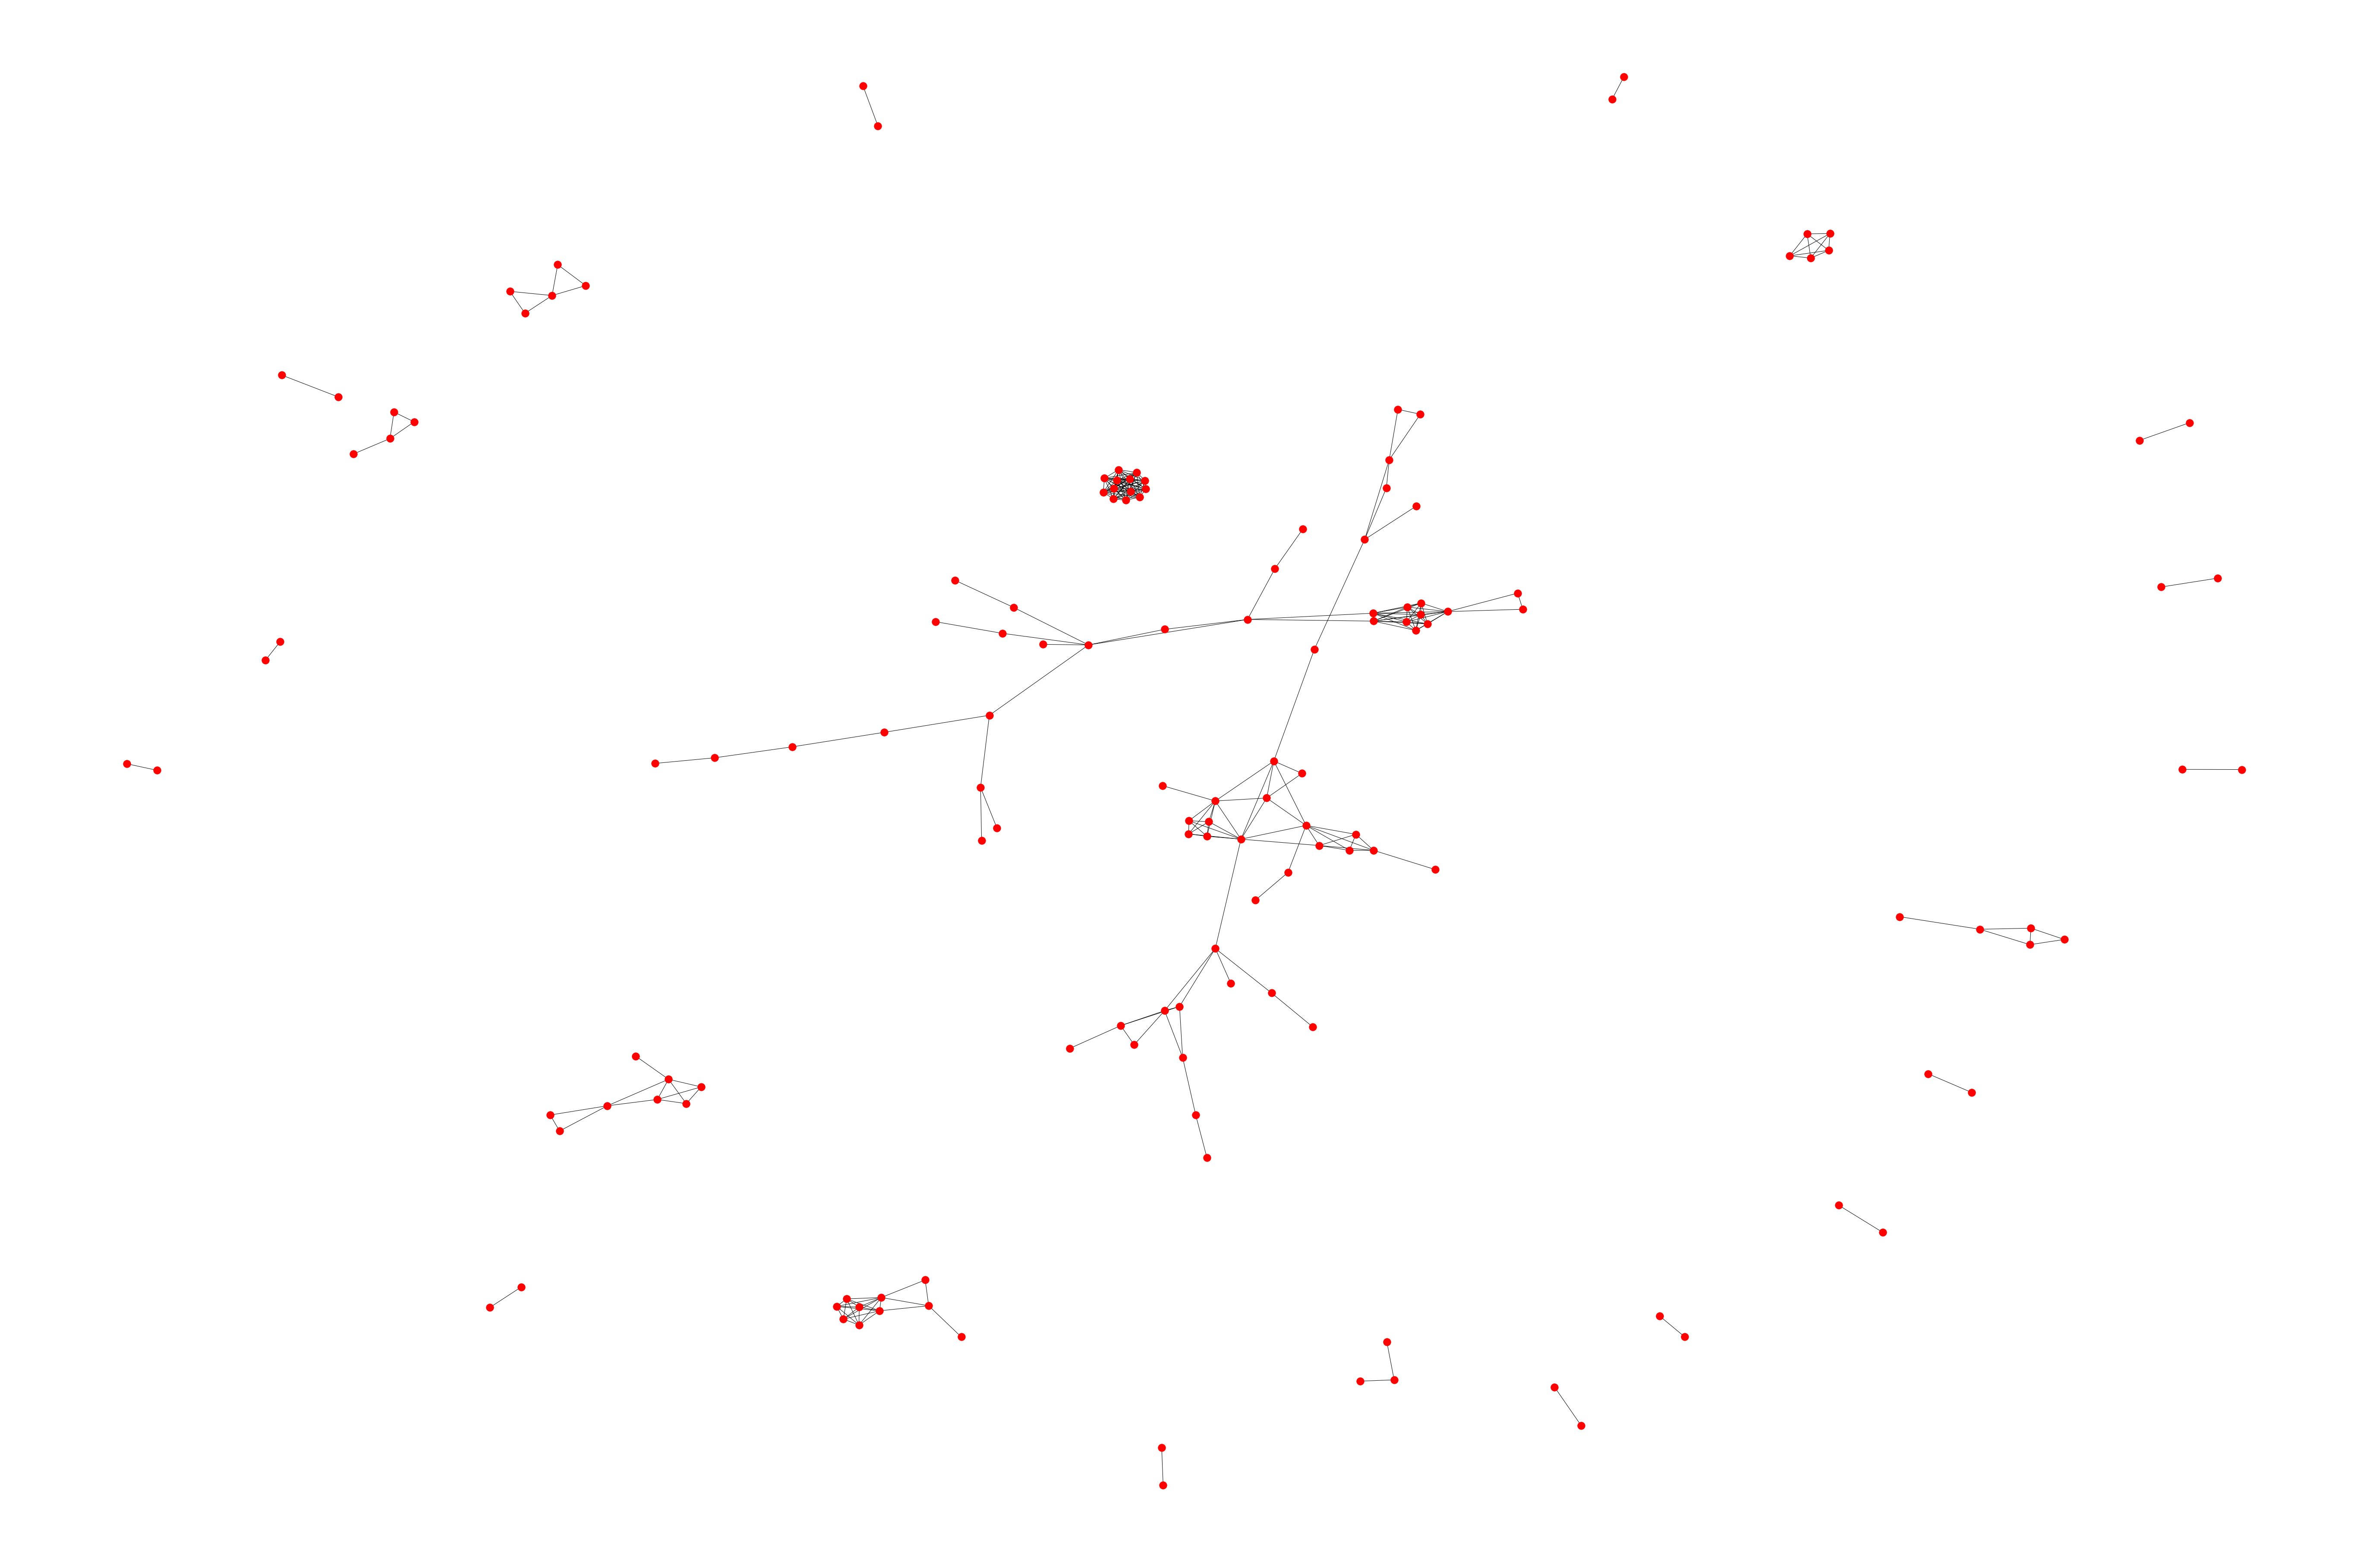

In [8]:
fig = plt.figure(figsize=(75, 50))
nx.draw_spring(g)
plt.show()

In [9]:
l = nx.spring_layout(g)

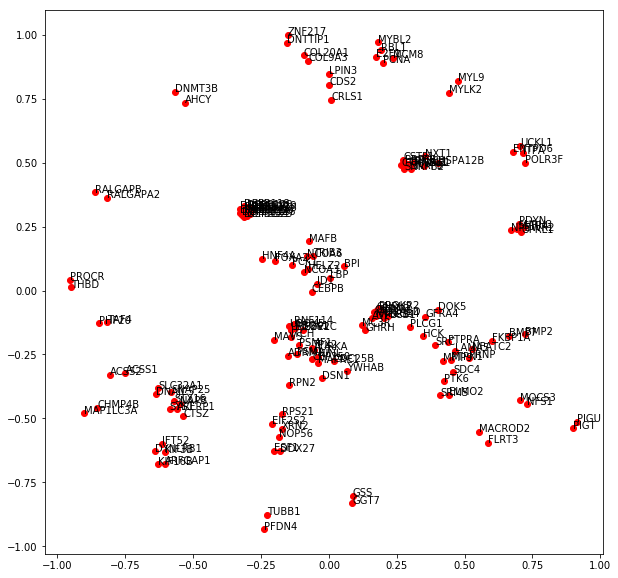

In [22]:
p = [None]*len(l)
x = [None]*len(l)
y = [None]*len(l)

i = 0
for k, v in l.items():
    p[i] = k
    x[i] = v[0]
    y[i] = v[1]
    i += 1

plt.figure(figsize=[10, 10])
plt.plot(x, y, 'ro')
for i in range(len(p)):
    plt.text(x[i], y[i], p[i])
plt.show()

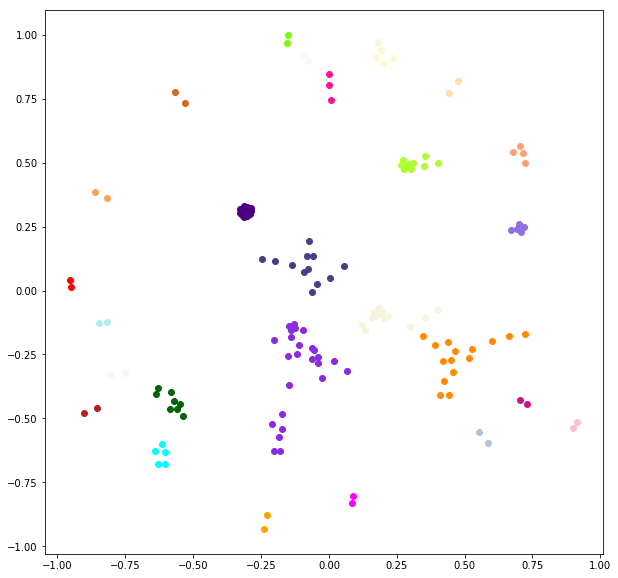

In [55]:
# TODO how to pick color palette?!
plt.figure(figsize=[10, 10])
colors=[v for k, v in mcolors.CSS4_COLORS.items()]
colors=[colors[i*5] for i in range(len(communities))]

for community, color in zip(communities, colors):
    for protein in community:
        pos = l[protein]
        plt.plot(pos[0], pos[1], color=color, marker='o')
        


plt.show()

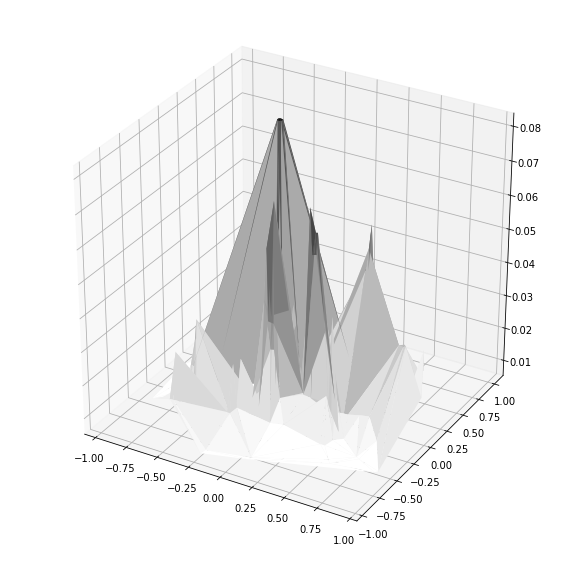

In [36]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

cen = nx.degree_centrality(g)
z = np.random.rand(len(x))
for i in range(len(x)):
    z[i] = cen[p[i]]
ax.plot_trisurf(x, y, z, linewidth=0.1, antialiased=True, cmap='gray_r', shade=True)
plt.show()

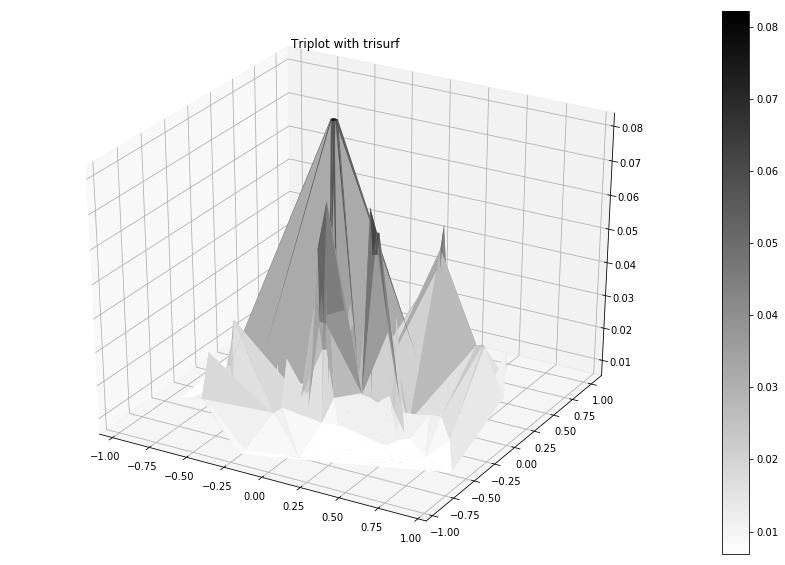

In [57]:
triang = mtri.Triangulation(x, y)
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(triang, z, linewidth=0.1, antialiased=True, cmap='gray_r', shade=True)
fig.colorbar(surf)
plt.title('Triplot with trisurf')
plt.show()

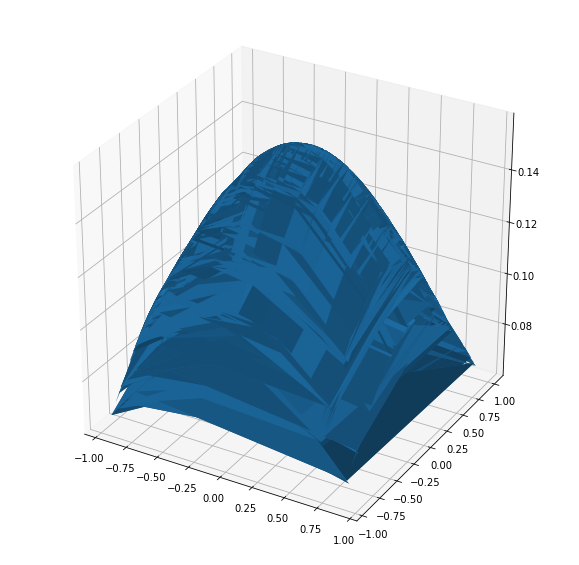

In [53]:
sigma = 1
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
x2d, y2d = np.meshgrid(x, y)
kernel_2d = np.exp(-(x2d ** 2 + y2d ** 2) / (2 * sigma ** 2))
kernel_2d = kernel_2d / (2 * np.pi * sigma ** 2) # unit integral
ax.plot_surface(x2d, y2d, kernel_2d)
plt.show()

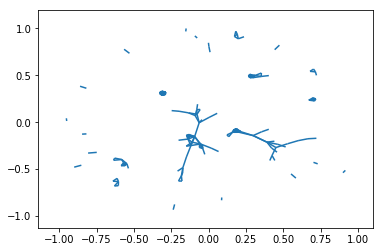

In [71]:
lines = [None]*len(edges)
for i, e in zip(range(len(edges)), edges):
    pos0 = l[e[0]]
    pos1 = l[e[1]]
    lines[i] = [(pos0[0], pos0[1]), (pos1[0], pos1[1])]
lc = mc.LineCollection(lines)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)




# TODO how to pick color palette?!
plt.figure(figsize=[10, 10])
colors=[v for k, v in mcolors.CSS4_COLORS.items()]
colors=[colors[i*5] for i in range(len(communities))]

for community, color in zip(communities, colors):
    for protein in community:
        pos = l[protein]
        plt.plot(pos[0], pos[1], color=color, marker='o')
        


plt.show()